In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
df = pd.read_csv("../Data/BrentOilPrices.csv", parse_dates=["Date"])
df = df.sort_values("Date")
df["log_price"] = np.log(df["Price"])
df["log_return"] = df["log_price"].diff()
df = df.dropna().reset_index(drop=True)
df.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_18332\2896185415.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("../Data/BrentOilPrices.csv", parse_dates=["Date"])


,Date,Price,log_price,log_return
0,1987-05-21,18.45,2.915064,-0.009709
1,1987-05-22,18.55,2.920470,0.005405
2,1987-05-25,18.60,2.923162,0.002692
3,1987-05-26,18.63,2.924773,0.001612
4,1987-05-27,18.60,2.923162,-0.001612


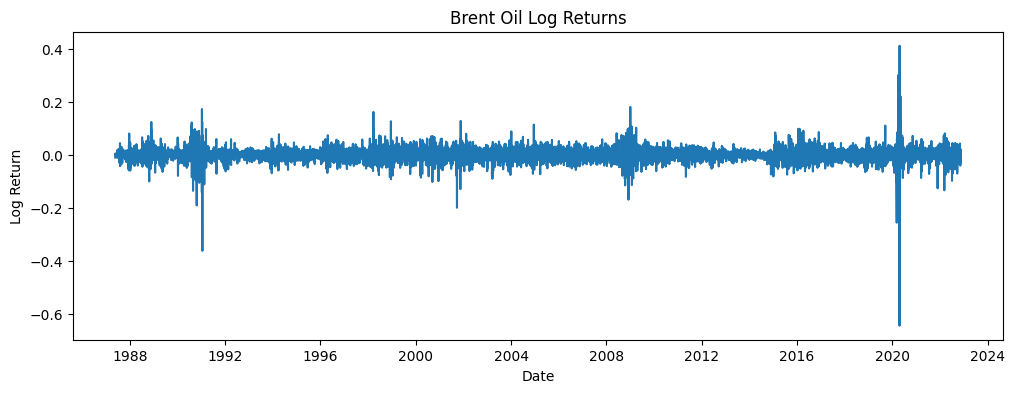

In [2]:
plt.figure(figsize=(12,4))
plt.plot(df["Date"], df["log_return"])
plt.title("Brent Oil Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()

In [3]:
returns = df["log_return"].values
n = len(returns)
with pm.Model() as model:
    tau = pm.DiscreteUniform("tau", lower=0, upper=n-1)
    mu1 = pm.Normal("mu1", mu=0, sigma=1)
    mu2 = pm.Normal("mu2", mu=0, sigma=1)
    sigma1 = pm.HalfNormal("sigma1", sigma=1)
    sigma2 = pm.HalfNormal("sigma2", sigma=1)
    mu = pm.math.switch(tau >= np.arange(n), mu1, mu2)
    sigma = pm.math.switch(tau >= np.arange(n), sigma1, sigma2)
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=returns)
    trace = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma1, sigma2]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 62 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


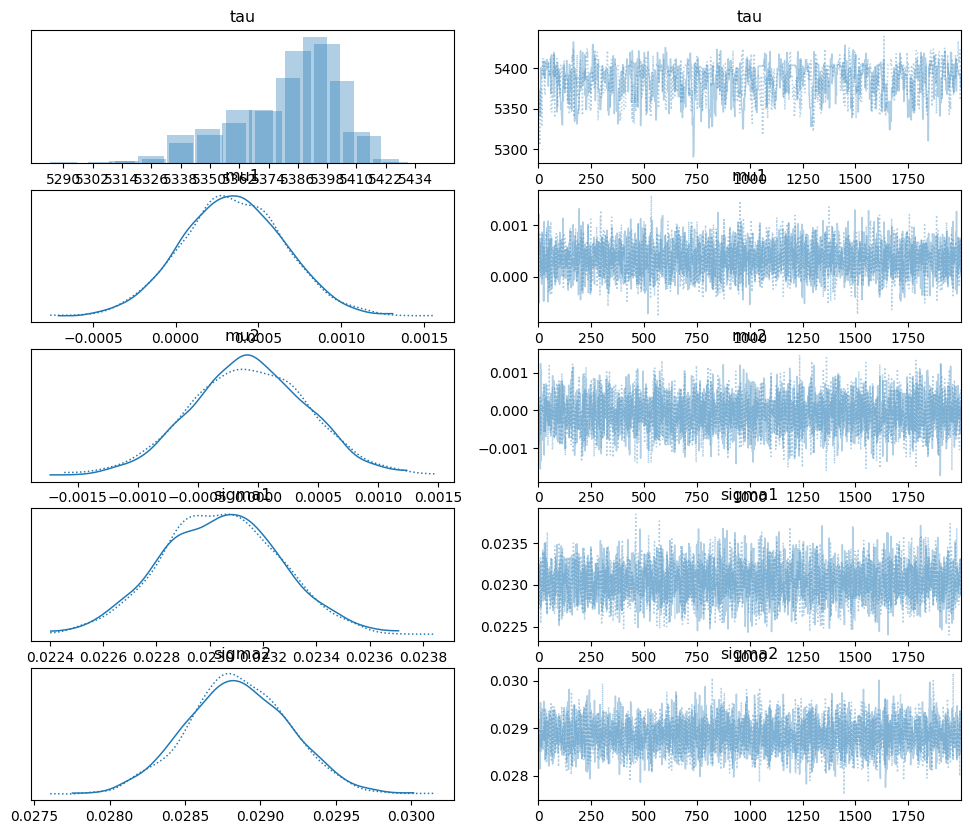

In [4]:
az.summary(trace, var_names=["tau", "mu1", "mu2", "sigma1", "sigma2"])
az.plot_trace(trace, var_names=["tau", "mu1", "mu2", "sigma1", "sigma2"])
plt.show()

In [5]:
tau_samples = trace.posterior["tau"].values.flatten()
tau_est = int(tau_samples.mean())
change_date = df.loc[tau_est, "Date"]
tau_est, change_date

(5386, Timestamp('2008-07-24 00:00:00'))

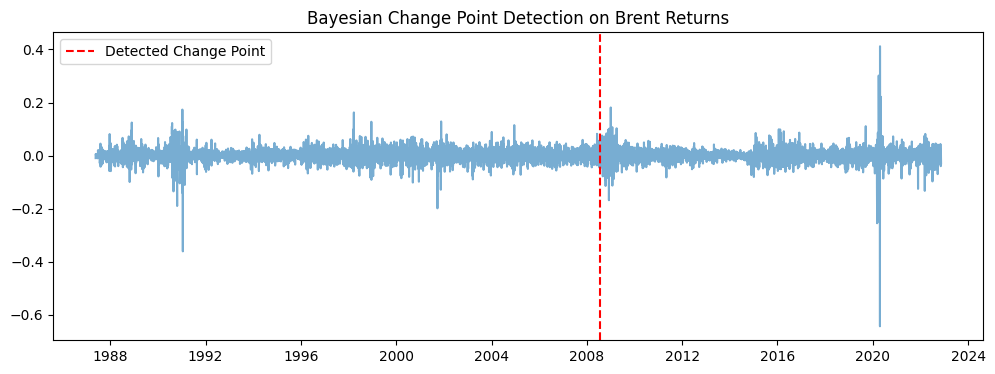

In [6]:
plt.figure(figsize=(12,4))
plt.plot(df["Date"], returns, alpha=0.6)
plt.axvline(change_date, color="red", linestyle="--", label="Detected Change Point")
plt.legend()
plt.title("Bayesian Change Point Detection on Brent Returns")
plt.show()

In [7]:
az.summary(trace, var_names=["mu1", "mu2", "sigma1", "sigma2"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu1,0.000,0.0,-0.000,0.001,0.0,0.0,4023.0,2852.0,1.0
mu2,-0.000,0.0,-0.001,0.001,0.0,0.0,4390.0,2748.0,1.0
sigma1,0.023,0.0,0.023,0.023,0.0,0.0,4374.0,2950.0,1.0
sigma2,0.029,0.0,0.028,0.030,0.0,0.0,4683.0,2841.0,1.0


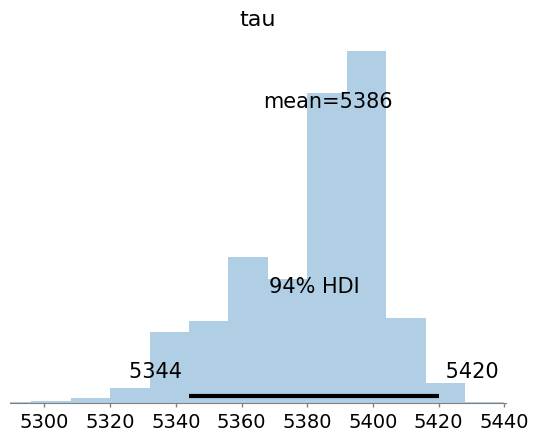

In [8]:
az.plot_posterior(trace, var_names=["tau"])
plt.show()

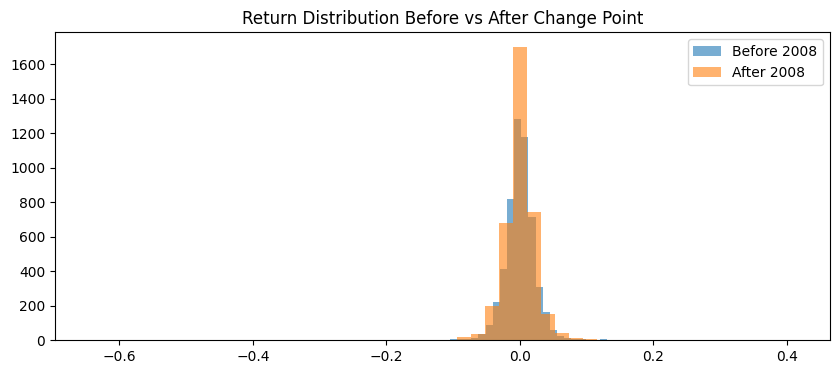

In [9]:
before = df[df["Date"] <= change_date]["log_return"]
after = df[df["Date"] > change_date]["log_return"]
plt.figure(figsize=(10,4))
plt.hist(before, bins=50, alpha=0.6, label="Before 2008")
plt.hist(after, bins=50, alpha=0.6, label="After 2008")
plt.legend()
plt.title("Return Distribution Before vs After Change Point")
plt.show()

In [10]:
import pytensor.tensor as pt
import numpy as np
n = len(df)
K = 3
with pm.Model() as multi_cp_model:
    taus = pm.DiscreteUniform("taus", lower=0, upper=n, shape=K)
    taus_sorted = pm.Deterministic("taus_sorted", pt.sort(taus))
    mus = pm.Normal("mus", mu=0, sigma=0.05, shape=K+1)
    sigmas = pm.HalfNormal("sigmas", sigma=0.05, shape=K+1)
    idx = np.arange(n)
    regime = pt.sum(idx[:, None] > taus_sorted, axis=1)
    mu = mus[regime]
    sigma = sigmas[regime]
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=df["log_return"].values)
    trace_multi = pm.sample(2000, tune=1000, target_accept=0.9)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [taus]
>NUTS: [mus, sigmas]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 156 seconds.
There were 2387 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [11]:
taus_post = trace_multi.posterior["taus_sorted"].mean(dim=("chain","draw")).values
change_dates = [df.iloc[int(t)]["Date"] for t in taus_post]
change_dates

[Timestamp('2005-01-17 00:00:00'),
 Timestamp('2005-02-17 00:00:00'),
 Timestamp('2005-11-21 00:00:00')]

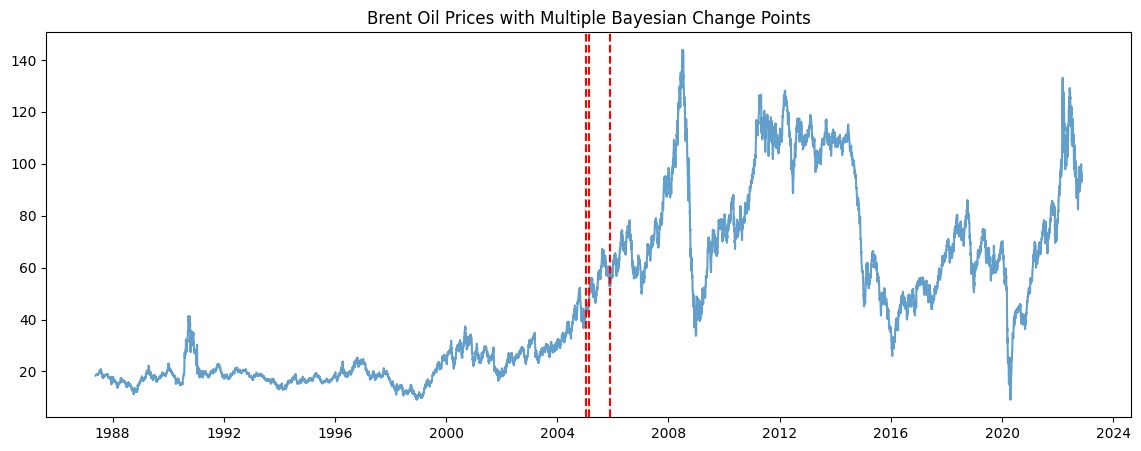

In [12]:
plt.figure(figsize=(14,5))
plt.plot(df["Date"], df["Price"], alpha=0.7)
for d in change_dates:
    plt.axvline(d, color="red", linestyle="--")
plt.title("Brent Oil Prices with Multiple Bayesian Change Points")
plt.show()

In [13]:
stats = []
prev = df["Date"].min()
for d in change_dates + [df["Date"].max()]:
    seg = df[(df["Date"] > prev) & (df["Date"] <= d)]
    stats.append((prev, d, seg["Price"].mean(), seg["Price"].std()))
    prev = d
pd.DataFrame(stats, columns=["Start","End","MeanPrice","Volatility"])

,Start,End,MeanPrice,Volatility
0,1987-05-21,2005-01-17,21.279303,6.948227
1,2005-01-17,2005-02-17,44.619130,1.153370
2,2005-02-17,2005-11-21,56.098163,5.343156
3,2005-11-21,2022-11-14,76.471494,25.535327


In [14]:
import pickle
with open("../Data/change_points.pkl", "wb") as f:
    pickle.dump(change_dates, f)